In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import urllib
import os
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
plt.style.use('ggplot')

## Background

Seeking data that may be integrated with model output we will look at ratios of different taxa and processes. In particular we will look at:

* ratios of heterotrophic prokaryotes to nitrifiers
* ratios between CO2 fixation (using Rubisco as proxy) by cyanobacteria, eukaryotes, nitrifiers and denitrifiers
* ratios between phosphonate, carbohydrate and protein transport


* Look at metatranscriptome total for taxonomic groups
* Look at metatrans total for functions (e.g. Rubisco & amoA genes)
* Look at rRNA mapping for OTUs


* Ratio between nitrifiers and heterotroph abundance based on metagenome
* Ratios between carbon fixation by cyanobacteria, eukaryotes, nitrifiers, denitrifiers
* Ratio between phosphonate, carbohydrate, protein (?) transport


**Nitrifiers**

Within the Nitrosomonadaceae:
Genera of ammonia-oxidizing bacteria (AOB):

- Nitrosomonas sp. (Betaproteobacteria) - https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=914 
- Nitrosospira sp. (Betaproteobacteria) - https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=35798
- Nitrosococcus sp. (Gammaproteobacteria) - https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=1227

In the Baltic it's probably Nitrosospira sp. There is also Nitrosovibrio sp. and more.. depending on how you search for them you can just search for all bacteria within the Nitrosomonadaceae or search for names with Nitroso***.

Phylum of ammonia-oxidizing archaea (AOA):
- Thaumarchaeota - https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=651137

Thaumarchaeal genera most probably relevant to the Baltic: Nitrosopumilus sp. and Nitrosoarchaeum sp. but potentially also others within the Thaumarchaeota.

### Calculating ratio between nitrifiers and heterotrophs

In [8]:
tpmr = pd.read_csv("data/mt/all_genes.tpm.taxonomy.tsv.gz", header=0, index_col=0, sep="\t")
#tpmd = pd.read_csv("data/mg/all_genes.tpm.taxonomy.tsv.gz", header=0, index_col=0, sep="\t")

In [6]:
def plot_nit_het_ratio(taxcov, outfig, outtab, title):
    ## Define nitrifiers and extract coverage
    ndict = {"phylum": ["Thaumarchaeota"], 
             "family": ["Nitrosomonadaceae"], 
             "genus": ["Nitrosococcus"]}
    nitrocov = taxcov.loc[(taxcov.phylum.isin(ndict["phylum"])) | (taxcov.family.isin(ndict["family"])) | (taxcov.genus.isin(ndict["genus"]))]
    ## Define heterotrophs
    ## Filter to prokaryotes but exclude Cyanobacteria and Unclassified.Bacteria
    h1 = taxcov.loc[(taxcov.superkingdom.isin(["Bacteria","Archaea"])) & (~taxcov.phylum.isin(["Cyanobacteria","Unclassified.Bacteria"]))]
    ## Filter out the nitrifiers
    h2 = h1.loc[(~h1.phylum.isin(ndict["phylum"])) & (~h1.family.isin(ndict["family"])) & (~h1.genus.isin(ndict["genus"]))]
    ## Filter out nitrifiers also on the lower ranks
    h3 = h2.loc[(h2["class"]!="Unclassified.Thaumarchaeota") & (h2["genus"]!="Unclassified.Nitrosomonadaceae") & (h2["species"]!="Unclassified.Nitrosococcus")]
    hetcov = h3.loc[(~h3["family"].isin(["Unclassified.Betaproteobacteria","Unclassified.Proteobacteria"]) & (~h3["genus"].isin(["Unclassified.Gammaproteobacteria","Unclassified.Proteobacteria"])))]
    ## Calculate sum for each group
    hetsum = hetcov.groupby("superkingdom").sum().sum()
    nitsum = nitrocov.groupby("superkingdom").sum().sum()
    ## Calculate ratio
    nit2het = nitsum.div(hetsum)
    
    ## Plot ratio
    rank="family"
    nitsum = nitrocov.groupby(rank).sum()
    df = pd.concat([nitsum,pd.DataFrame(nit2het,columns=["Nit:Het"]).T])
    ax1 = df.drop("Nit:Het").T.plot(kind="bar",stacked=True, legend=None)
    ax2 = df.loc["Nit:Het"].T.plot(ax=ax1, secondary_y=True, style="k--")
    ax1.legend(bbox_to_anchor=(1.9,1))
    ax1.set_ylabel("TPM")
    ax2.legend()
    ax1.set_title(title)
    plt.setp(ax1.get_xticklabels(), rotation=90);
    plt.setp(ax2.get_xticklabels(), rotation=90);
    xmin, xmax = ax1.get_xlim()
    ax1.set_xlim(xmin-0.5, xmax+0.5)
    plt.savefig(outfig, dpi=300, bbox_inches="tight")
    df.to_csv(outtab, sep="\t")

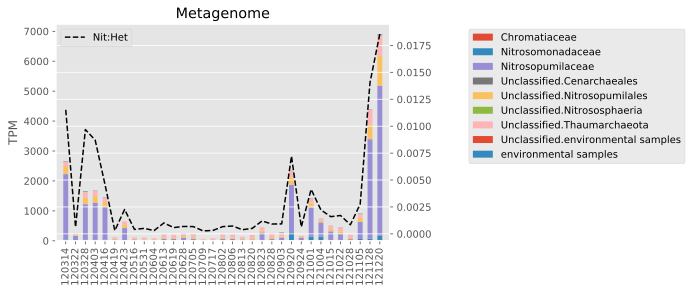

In [7]:
plot_nit_het_ratio(tpmd, outfig="model/figures/lmo_nit2hetratio_metagenome.png", outtab="model/results/lmo_nit2hetratio_metagenome.tab", title="Metagenome")

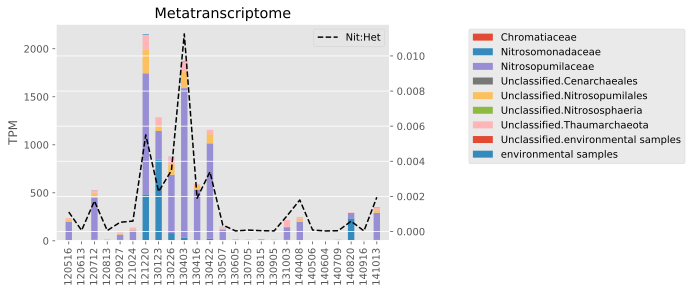

In [11]:
plot_nit_het_ratio(tpmr, outfig="model/figures/lmo_nit2hetratio_metatrans.png", outtab="model/results/lmo_nit2hetratio_metatranscriptome.tab", title="Metatranscriptome")

### Calculating CO2 fixation ratios by taxa

In [13]:
# Use the RbcL pfam as proxy for CO2 fixation
co2 = ["PF00016"]

In [10]:
# Download the pfam annotation data from Figshare 
url = "https://ndownloader.figshare.com/files/9448024"
os.makedirs("data/", exist_ok=True)
annot_data = urllib.request.urlretrieve(url, "data/all.pfam.standardized.tsv.gz")
pfams = pd.read_csv("data/all.pfam.standardized.tsv.gz", header=None, sep="\t", index_col=0, usecols=[0,1],names=["orf","pfam"])

In [14]:
mg_pfamcov = pd.merge(pfams,tpmd,left_index=True,right_index=True)

In [15]:
mt_pfamcov = pd.merge(pfams,tpmr,left_index=True,right_index=True)

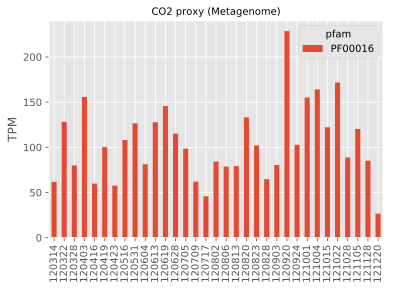

In [16]:
mg_co2cov = mg_pfamcov.loc[mg_pfamcov.pfam.isin(co2)]
ax = mg_co2cov.groupby("pfam").sum().T.plot(kind="bar");
ax.set_ylabel("TPM")
ax.set_title("CO2 proxy (Metagenome)",fontsize=10)
plt.savefig("model/figures/mg_CO2_total.png",dpi=300,bbox_inches="tight")

#### Monthly average

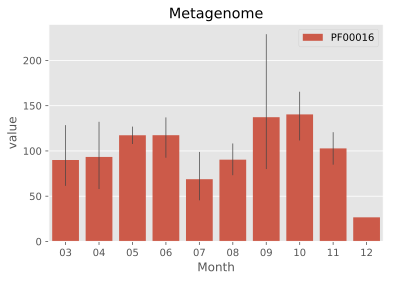

In [17]:
_ = pd.melt(mg_co2cov.groupby("pfam").sum().reset_index(), id_vars=["pfam"], var_name="Date")
_.columns = ["RbcL", "Date", "value"]
months = ["".join(list(x)[2:4]) for x in _.Date]
_ = _.assign(Month=pd.Series(months, index=_.index))
ax = sns.barplot(data=_, x="Month", y="value", hue="RbcL", errwidth=.7)
ax.legend(bbox_to_anchor=(1,1))
ax.set_title("Metagenome")
plt.savefig("model/figures/mg_CO2_total_monthly.png", dpi=300, bbox_to_inches="tight")
pd.pivot_table(_.groupby(["RbcL","Month"]).mean().reset_index(), columns="Month", index="RbcL")["value"].to_csv("model/results/mg_CO2_monthly.tsv", sep="\t")

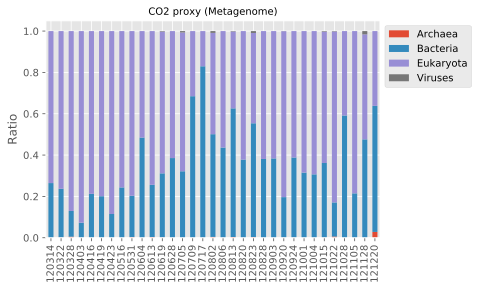

In [18]:
mg_co2cov_kingdom = mg_co2cov.groupby(["pfam","superkingdom"]).sum().reset_index().groupby("superkingdom").sum()
ax = mg_co2cov_kingdom.div(mg_co2cov_kingdom.sum()).T.plot(kind="bar",stacked=True)
ax.set_title("CO2 proxy (Metagenome)", fontsize=10)
ax.set_ylabel("Ratio")
plt.legend(bbox_to_anchor=(1,1))
plt.savefig("model/figures/mg_CO2_kingdoms.png", dpi=300, bbox_inches="tight")
mg_co2cov_kingdom.to_csv("model/results/mg_CO2_kingdoms.tsv", sep="\t")

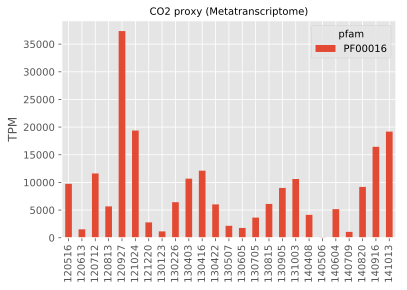

In [19]:
mt_co2cov = mt_pfamcov.loc[mt_pfamcov.pfam.isin(co2)]
ax = mt_co2cov.groupby("pfam").sum().T.plot(kind="bar");
ax.set_ylabel("TPM")
ax.set_title("CO2 proxy (Metatranscriptome)",fontsize=10)
plt.savefig("model/figures/mt_CO2_total.png",dpi=300,bbox_inches="tight")

#### Montly average

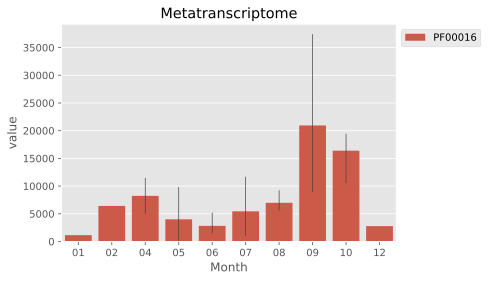

In [20]:
_ = pd.melt(mt_co2cov.groupby("pfam").sum().reset_index(), id_vars=["pfam"], var_name="Date")
_.columns = ["RbcL", "Date", "value"]
months = ["".join(list(x)[2:4]) for x in _.Date]
_ = _.assign(Month=pd.Series(months, index=_.index))
ax = sns.barplot(data=_, x="Month", y="value", hue="RbcL", errwidth=.7)
ax.legend(bbox_to_anchor=(1,1))
ax.set_title("Metatranscriptome")
plt.savefig("model/figures/mt_CO2_total_monthly.png", dpi=300, bbox_to_inches="tight")
pd.pivot_table(_.groupby(["RbcL","Month"]).mean().reset_index(), columns="Month", index="RbcL")["value"].to_csv("model/results/mt_CO2_monthly.tsv", sep="\t")

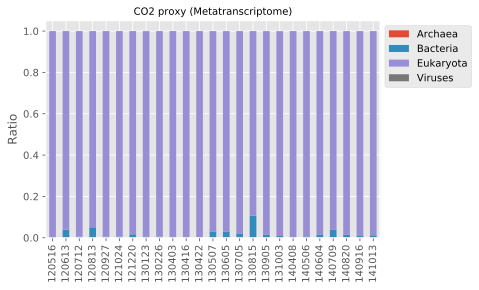

In [21]:
mt_co2cov_kingdom = mt_co2cov.groupby(["pfam","superkingdom"]).sum().reset_index().groupby("superkingdom").sum()
ax = mt_co2cov_kingdom.div(mt_co2cov_kingdom.sum()).T.plot(kind="bar",stacked=True)
ax.set_title("CO2 proxy (Metatranscriptome)", fontsize=10)
ax.set_ylabel("Ratio")
plt.legend(bbox_to_anchor=(1,1))
plt.savefig("model/figures/mt_CO2_kingdoms.png", dpi=300, bbox_inches="tight")
mg_co2cov_kingdom.to_csv("model/results/mt_CO2_kingdoms.tsv", sep="\t")

## Read transporter abundances

In [22]:
mg_trans = pd.read_table("results/mg/bac_select_trans.tpm.tsv")
mt_trans = pd.read_table("results/mt/bac_select_trans.tpm.tsv")

### Add alkaline phosphatases

In [23]:
alk_pfams_def = pd.DataFrame(data={"transporter":["phoA","phoD","phoX","phoD-like"],"fam":["PF00245","PF01663","PF05787","PF09423"]})
alk_pfams_info = pd.DataFrame(index=["phoA","phoD","phoX","phoD-like"],data={"substrate_category":["phosphonate"]*4,"abbreviation": ["PO"]*4, "name":["Alkaline phosphatase phoA","Alkaline phosphatase phoD","Alkaline phosphatase phoX","Alkaline phosphatase phoD-like"]})
alk_pfams_info.index.name="transporter"
alk_pfams_info = alk_pfams_info.reset_index()
alk_pfams_def

,fam,transporter
0,PF00245,phoA
1,PF01663,phoD
2,PF05787,phoX
3,PF09423,phoD-like


In [24]:
mg_alk = pd.merge(mg_pfamcov, alk_pfams_def, left_on="pfam", right_on="fam")
mg_alk_sum = mg_alk.groupby("transporter").sum()
mg_alk_sum = pd.merge(alk_pfams_info,mg_alk_sum, right_index=True, left_on="transporter")
mg_trans_alk = pd.concat([mg_alk_sum,mg_trans])[mg_alk_sum.columns]

In [25]:
mt_alk = pd.merge(mt_pfamcov, alk_pfams_def, left_on="pfam", right_on="fam")
mt_alk_sum = mt_alk.groupby("transporter").sum()
mt_alk_sum = pd.merge(alk_pfams_info,mt_alk_sum, right_index=True, left_on="transporter")
mt_trans_alk = pd.concat([mt_alk_sum,mt_trans])[mt_alk_sum.columns]

### Ratios between phosphonate, carbohydrate and protein transport

In [26]:
N_cats = ["AA peptide","NH3 Nitrate","Urea"]

In [27]:
organic_acids_t = list(mg_trans_alk.loc[mg_trans_alk.name.str.contains("TRAP"),"transporter"]) + \
list(mg_trans_alk.loc[mg_trans_alk.name.str.contains("malonate"),"transporter"])
simplesugars_t = list(mg_trans_alk.loc[mg_trans_alk.name.str.contains("sugar"),"transporter"]) + \
list(mg_trans_alk.loc[mg_trans_alk.name.str.contains("glucose"),"transporter"]) + \
list(mg_trans_alk.loc[mg_trans_alk.name.str.contains("fucose"),"transporter"])
cpdom_t = list(mg_trans_alk.loc[mg_trans_alk.substrate_category=="phosphonate","transporter"])
peps_t = list(mg_trans_alk.loc[mg_trans_alk.substrate_category.isin(N_cats),"transporter"])
other_t = set(mg_trans_alk.transporter).difference(set(organic_acids_t+simplesugars_t+cpdom_t+peps_t))

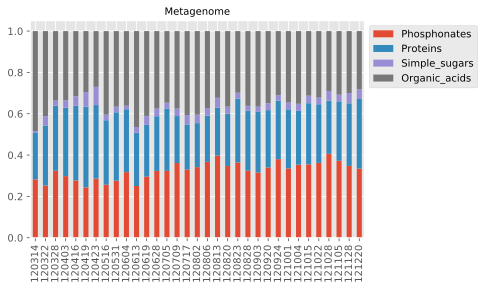

In [28]:
phos = mg_trans_alk.loc[mg_trans_alk["substrate_category"]=="phosphonate"]
#carb = mg_trans_alk.loc[mg_trans_alk["substrate_category"]=="carbohydrate"]
carb_sug = mg_trans_alk.loc[mg_trans_alk["transporter"].isin(simplesugars_t)]
carb_aci = mg_trans_alk.loc[mg_trans_alk["transporter"].isin(organic_acids_t)]
#carb_oth = mg_trans_alk.loc[mg_trans_alk["transporter"].isin(other_carb)]
prot = mg_trans_alk.loc[mg_trans_alk["substrate_category"]=="AA peptide"]
carbsum = pd.concat([carb_sug.groupby("substrate_category").sum(),carb_aci.groupby("substrate_category").sum()])
carbsum.index = ["Simple_sugars","Organic_acids"]
phossum = phos.groupby("substrate_category").sum().sum()
#carbsum = carb.groupby("substrate_category").sum().sum()
protsum = prot.groupby("substrate_category").sum().sum()

mg_transratio = pd.DataFrame(data=[phossum,protsum],index=["Phosphonates","Proteins"])
mg_transratio = pd.concat([mg_transratio, carbsum])
mg_transration = mg_transratio.div(mg_transratio.sum())
ax = mg_transration.T.plot(kind="bar",stacked=True)
ax.set_title("Metagenome", fontsize=10)
plt.legend(bbox_to_anchor=(1,1));
mg_transration.to_csv("model/results/mg_p_c_aa_ratios.tsv", sep="\t")
plt.savefig("model/figures/mg_p_c_aa_ratios.png", dpi=300, bbox_inches="tight")

#### Monthly average

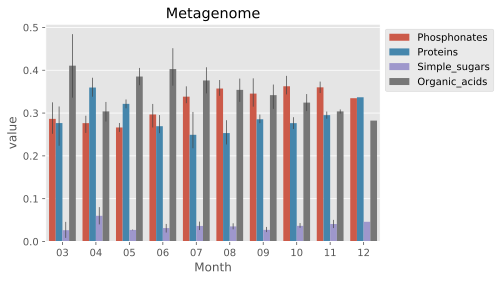

In [29]:
_ = pd.melt(mg_transration.reset_index(), id_vars=["index"], var_name="Date")
_.columns = ["substrate", "Date", "value"]
months = ["".join(list(x)[2:4]) for x in _.Date]
_ = _.assign(Month=pd.Series(months, index=_.index))
ax = sns.barplot(data=_, x="Month", y="value", hue="substrate", errwidth=.7)
ax.legend(bbox_to_anchor=(1,1))
ax.set_title("Metagenome")
pd.pivot_table(_.groupby(["substrate", "Month"]).mean().reset_index(), columns="Month",index="substrate")["value"].to_csv("model/results/mg_p_c_aa_ratios_monthly.tsv", sep="\t")
plt.savefig("model/figures/mg_p_c_aa_ratios_monthly.png", dpi=300, bbox_to_inches="tight")

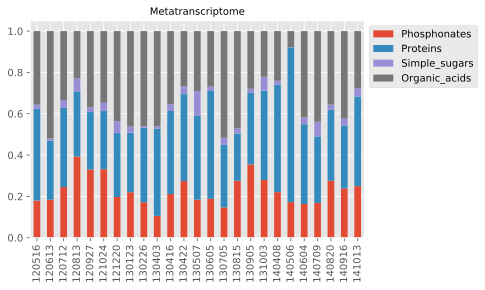

In [30]:
phos = mt_trans_alk.loc[mt_trans_alk["substrate_category"]=="phosphonate"]
#carb = mt_trans_alk.loc[mt_trans_alk["substrate_category"]=="carbohydrate"]
carb_sug = mt_trans_alk.loc[mt_trans_alk["transporter"].isin(simplesugars_t)]
carb_aci = mt_trans_alk.loc[mt_trans_alk["transporter"].isin(organic_acids_t)]
#carb_oth = mt_trans_alk.loc[mt_trans_alk["transporter"].isin(other_carb)]
prot = mt_trans_alk.loc[mt_trans_alk["substrate_category"]=="AA peptide"]
carbsum = pd.concat([carb_sug.groupby("substrate_category").sum(),carb_aci.groupby("substrate_category").sum()])
carbsum.index = ["Simple_sugars","Organic_acids"]
phossum = phos.groupby("substrate_category").sum().sum()
#carbsum = carb.groupby("substrate_category").sum().sum()
protsum = prot.groupby("substrate_category").sum().sum()

mt_transratio = pd.DataFrame(data=[phossum,protsum],index=["Phosphonates","Proteins"])
mt_transratio = pd.concat([mt_transratio, carbsum])
mt_transration = mt_transratio.div(mt_transratio.sum())
ax = mt_transration.T.plot(kind="bar",stacked=True)
ax.set_title("Metatranscriptome", fontsize=10)
plt.legend(bbox_to_anchor=(1,1));
mt_transration.to_csv("model/results/mt_p_c_aa_ratios.tsv", sep="\t")
plt.savefig("model/figures/mt_p_c_aa_ratios.png", dpi=300, bbox_inches="tight")

#### Monthly average

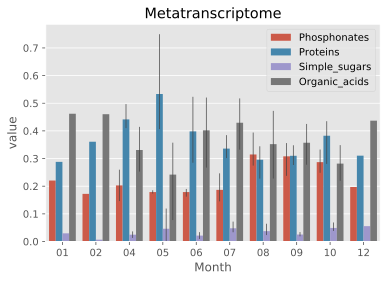

In [31]:
_ = pd.melt(mt_transration.reset_index(), id_vars=["index"], var_name="Date")
_.columns = ["substrate", "Date", "value"]
months = ["".join(list(x)[2:4]) for x in _.Date]
_ = _.assign(Month=pd.Series(months, index=_.index))
ax = sns.barplot(data=_, x="Month", y="value", hue="substrate", errwidth=.7)
ax.legend(bbox_to_anchor=(1,1))
ax.set_title("Metatranscriptome")
pd.pivot_table(_.groupby(["substrate", "Month"]).mean().reset_index(), columns="Month",index="substrate")["value"].to_csv("model/results/mt_p_c_aa_ratios_monthly.tsv", sep="\t")
plt.savefig("model/figures/mt_p_c_aa_ratios_monthly.png", dpi=300, bbox_to_inches="tight")

### Phosphate ratio plots

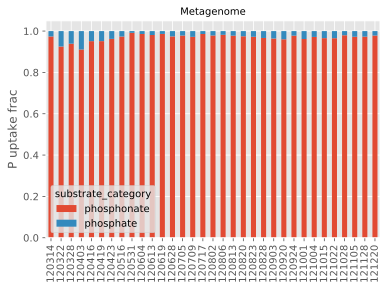

In [33]:
po = mg_trans_alk.loc[mg_trans_alk["substrate_category"]=="phosphonate"].groupby("substrate_category").sum()
pi = mg_trans_alk.loc[mg_trans_alk["substrate_category"]=="phosphate"].groupby("substrate_category").sum()
p = pd.concat([po,pi])
mg_p_rat = p.div(p.sum())
ax = mg_p_rat.T.plot(kind="bar",stacked=True)
ax.set_ylabel("P uptake frac")
ax.set_title("Metagenome", fontsize=10)
p.div(p.sum()).to_csv("model/results/mg_pi2po_ratio.tsv", sep="\t")
plt.savefig("model/figures/mg_p_ratio.png", dpi=300, bbox_inches="tight")

#### Monthly average

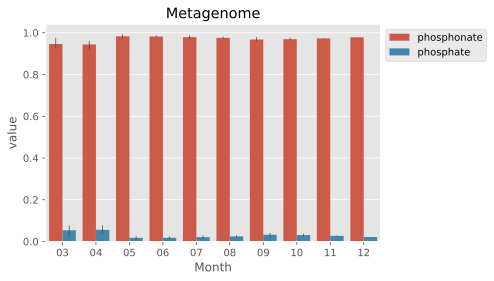

In [34]:
_ = pd.melt(mg_p_rat.reset_index(), id_vars=["substrate_category"], var_name="Date")
_.columns = ["substrate", "Date", "value"]
months = ["".join(list(x)[2:4]) for x in _.Date]
_ = _.assign(Month=pd.Series(months, index=_.index))
ax = sns.barplot(data=_, x="Month", y="value", hue="substrate", errwidth=.7)
ax.legend(bbox_to_anchor=(1,1))
ax.set_title("Metagenome")
pd.pivot_table(_.groupby(["substrate", "Month"]).mean().reset_index(), columns="Month",index="substrate")["value"].to_csv("model/results/mg_pi2po_ratio_monthly.tsv", sep="\t")
plt.savefig("model/figures/mg_p_ratio_monthly.png", dpi=300, bbox_to_inches="tight")

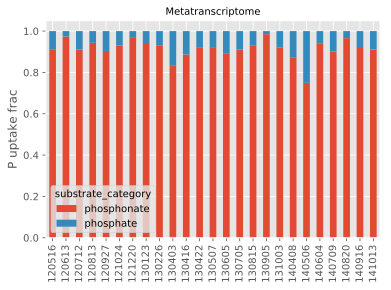

In [35]:
po = mt_trans_alk.loc[mt_trans_alk["substrate_category"]=="phosphonate"].groupby("substrate_category").sum()
pi = mt_trans_alk.loc[mt_trans_alk["substrate_category"]=="phosphate"].groupby("substrate_category").sum()
p = pd.concat([po,pi])
mt_p_rat = p.div(p.sum())
ax = mt_p_rat.T.plot(kind="bar",stacked=True)
ax.set_ylabel("P uptake frac")
ax.set_title("Metatranscriptome", fontsize=10)
p.div(p.sum()).to_csv("model/results/mt_pi2po_ratio.tsv", sep="\t")
plt.savefig("model/figures/mt_p_ratio.png", dpi=300, bbox_inches="tight")

#### Monthly average

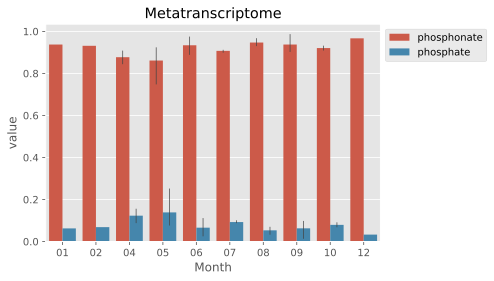

In [36]:
_ = pd.melt(mt_p_rat.reset_index(), id_vars=["substrate_category"], var_name="Date")
_.columns = ["substrate", "Date", "value"]
months = ["".join(list(x)[2:4]) for x in _.Date]
_ = _.assign(Month=pd.Series(months, index=_.index))
ax = sns.barplot(data=_, x="Month", y="value", hue="substrate", errwidth=.7)
ax.legend(bbox_to_anchor=(1,1))
ax.set_title("Metatranscriptome")
pd.pivot_table(_.groupby(["substrate", "Month"]).mean().reset_index(), columns="Month",index="substrate")["value"].to_csv("model/results/mt_pi2po_ratio_monthly.tsv", sep="\t")
plt.savefig("model/figures/mt_p_ratio_monthly.png", dpi=300, bbox_to_inches="tight")

### Nitrogen ratio plots

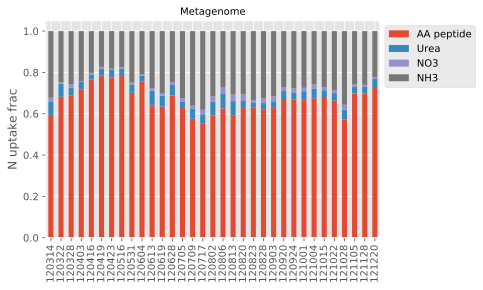

In [37]:
N_cats = ["AA peptide","Urea"]
nh3_t = "T133"
no3_t = "T31"
mg_n_trans = mg_trans.loc[mg_trans.substrate_category.isin(N_cats)]
mg_n_trans_sum = mg_n_trans.groupby("substrate_category").sum()
NH3 = mg_trans.loc[mg_trans.transporter==nh3_t].groupby("transporter").sum()
NO3 = mg_trans.loc[mg_trans.transporter==no3_t].groupby("transporter").sum()
NO3.index = [no3_t]
NH3.index = [nh3_t]
mg_n_trans_sum = pd.concat([pd.concat([mg_n_trans_sum,NO3]),NH3])
mg_n_trans_sum.index = ["AA peptide", "Urea", "NO3", "NH3"]
mg_n_trans_sum

mg_n_trans_rat = mg_n_trans_sum.div(mg_n_trans_sum.sum())
ax = mg_n_trans_rat.T.plot(kind="bar",stacked=True)
ax.set_title("Metagenome", fontsize=10)
ax.set_ylabel("N uptake frac")
ax.legend(bbox_to_anchor=(1,1))
mg_n_trans_rat.to_csv("model/results/mg_n_ratios.tsv", sep="\t")
plt.savefig("model/figures/mg_n_ratio.png", dpi=300, bbox_inches="tight")

#### Monthly average

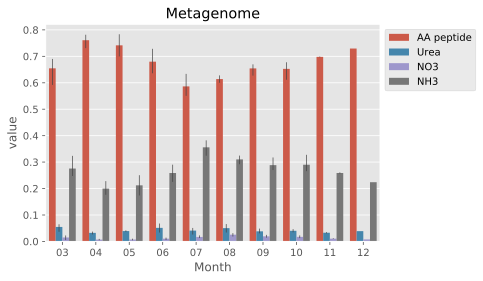

In [38]:
_ = pd.melt(mg_n_trans_rat.reset_index(), id_vars=["index"], var_name="Date")
_.columns = ["substrate", "Date", "value"]
months = ["".join(list(x)[2:4]) for x in _.Date]
_ = _.assign(Month=pd.Series(months, index=_.index))
ax = sns.barplot(data=_, x="Month", y="value", hue="substrate", errwidth=.7)
ax.legend(bbox_to_anchor=(1,1))
ax.set_title("Metagenome")
pd.pivot_table(_.groupby(["substrate", "Month"]).mean().reset_index(), columns="Month",index="substrate")["value"].to_csv("model/results/mg_n_ratios_monthly.tsv", sep="\t")
plt.savefig("model/figures/mg_n_ratio_monthly.png", dpi=300, bbox_to_inches="tight")

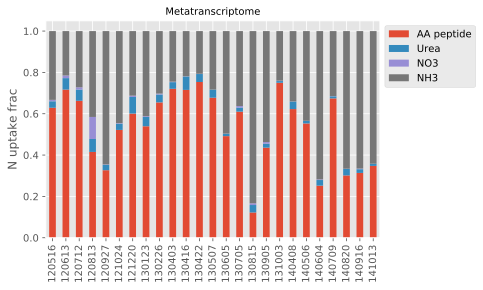

In [39]:
N_cats = ["AA peptide","Urea"]
nh3_t = "T133"
no3_t = "T31"
mt_n_trans = mt_trans.loc[mt_trans.substrate_category.isin(N_cats)]
mt_n_trans_sum = mt_n_trans.groupby("substrate_category").sum()
NH3 = mt_trans.loc[mt_trans.transporter==nh3_t].groupby("transporter").sum()
NO3 = mt_trans.loc[mt_trans.transporter==no3_t].groupby("transporter").sum()
NO3.index = [no3_t]
NH3.index = [nh3_t]
mt_n_trans_sum = pd.concat([pd.concat([mt_n_trans_sum,NO3]),NH3])
mt_n_trans_sum.index = ["AA peptide", "Urea", "NO3", "NH3"]
mt_n_trans_sum

mt_n_trans_rat = mt_n_trans_sum.div(mt_n_trans_sum.sum())
ax = mt_n_trans_rat.T.plot(kind="bar",stacked=True)
ax.set_title("Metatranscriptome", fontsize=10)
ax.set_ylabel("N uptake frac")
ax.legend(bbox_to_anchor=(1,1))
mt_n_trans_rat.to_csv("model/results/mt_n_ratios.tsv", sep="\t")
plt.savefig("model/figures/mt_n_ratio.png", dpi=300, bbox_inches="tight")

#### Monthly average

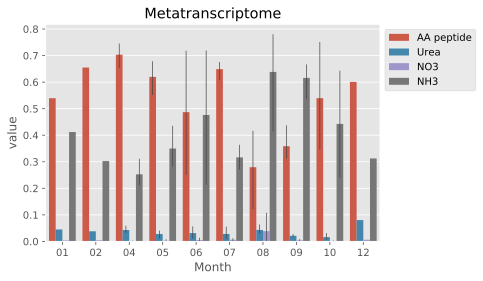

In [40]:
_ = pd.melt(mt_n_trans_rat.reset_index(), id_vars=["index"], var_name="Date")
_.columns = ["substrate", "Date", "value"]
months = ["".join(list(x)[2:4]) for x in _.Date]
_ = _.assign(Month=pd.Series(months, index=_.index))
ax = sns.barplot(data=_, x="Month", y="value", hue="substrate", errwidth=.7)
ax.legend(bbox_to_anchor=(1,1))
ax.set_title("Metatranscriptome")
pd.pivot_table(_.groupby(["substrate", "Month"]).mean().reset_index(), columns="Month",index="substrate")["value"].to_csv("model/results/mt_n_ratios_monthly.tsv", sep="\t")
plt.savefig("model/figures/mt_n_ratio_monthly.png", dpi=300, bbox_to_inches="tight")

### Carbohydrate ratio plots

In [41]:
organic_acids_t = list(mg_trans_alk.loc[mg_trans_alk.name.str.contains("TRAP"),"transporter"]) + \
list(mg_trans_alk.loc[mg_trans_alk.name.str.contains("malonate"),"transporter"])
simplesugars_t = list(mg_trans_alk.loc[mg_trans_alk.name.str.contains("sugar"),"transporter"]) + \
list(mg_trans_alk.loc[mg_trans_alk.name.str.contains("glucose"),"transporter"]) + \
list(mg_trans_alk.loc[mg_trans_alk.name.str.contains("fucose"),"transporter"])
cpdom_t = list(mg_trans_alk.loc[mg_trans_alk.substrate_category=="phosphonate","transporter"])
peps_t = list(mg_trans_alk.loc[mg_trans_alk.substrate_category.isin(N_cats),"transporter"])
other_t = set(mg_trans_alk.transporter).difference(set(organic_acids_t+simplesugars_t+cpdom_t+peps_t))

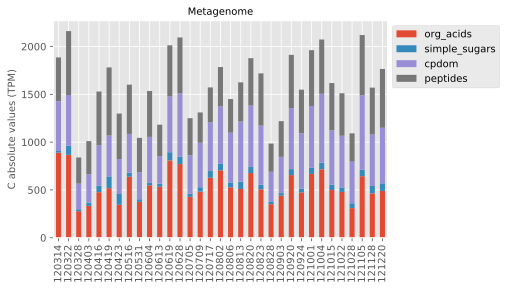

In [42]:
mg_org_aci_sum = mg_trans_alk.loc[mg_trans_alk.transporter.isin(organic_acids_t)].groupby("transporter").sum().sum()
mg_sim_sug_sum = mg_trans_alk.loc[mg_trans_alk.transporter.isin(simplesugars_t)].groupby("transporter").sum().sum()
mg_cpdom_sum = mg_trans_alk.loc[mg_trans_alk.transporter.isin(cpdom_t)].groupby("transporter").sum().sum()
mg_pep_sum = mg_trans_alk.loc[mg_trans_alk.transporter.isin(peps_t)].groupby("transporter").sum().sum()
mg_other_sum = mg_trans_alk.loc[mg_trans_alk.transporter.isin(other_t)].groupby("transporter").sum().sum()

mg_c_ratio = pd.DataFrame()
mg_c_ratio = mg_c_ratio.assign(org_acids=pd.Series(mg_org_aci_sum))
mg_c_ratio = mg_c_ratio.assign(simple_sugars=pd.Series(mg_sim_sug_sum))
mg_c_ratio = mg_c_ratio.assign(cpdom=pd.Series(mg_cpdom_sum))
mg_c_ratio = mg_c_ratio.assign(peptides=pd.Series(mg_pep_sum))
#mg_c_ratio = mg_c_ratio.assign(other=pd.Series(mg_other_sum))

mg_c_ration = mg_c_ratio.T.div(mg_c_ratio.T.sum())

ax = mg_c_ratio.plot(kind="bar", stacked=True)
ax.set_ylabel("C absolute values (TPM)", fontsize=10)
ax.set_title("Metagenome", fontsize=10)
plt.legend(bbox_to_anchor=(1,1))
mg_c_ratio.to_csv("model/results/mg_c_ratios_absolute.tsv", sep="\t")
plt.savefig("model/figures/mg_c_ratios_absolute.png", dpi=300, bbox_inches="tight")

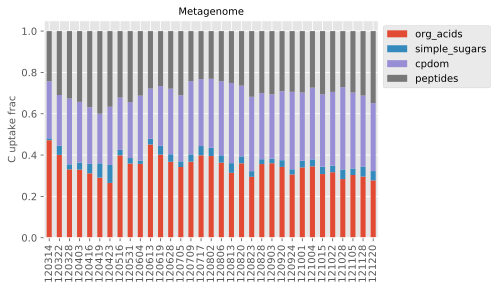

In [43]:
ax = mg_c_ration.T.plot(kind="bar", stacked=True)
ax.set_ylabel("C uptake frac", fontsize=10)
ax.set_title("Metagenome", fontsize=10)
plt.legend(bbox_to_anchor=(1,1))
mg_c_ration.to_csv("model/results/mg_c_ratios.tsv", sep="\t")
plt.savefig("model/figures/mg_c_ratios.png", dpi=300, bbox_inches="tight")

#### Monthly averages

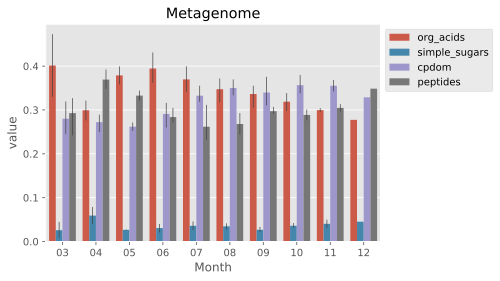

In [44]:
_ = pd.melt(mg_c_ration.reset_index(), id_vars=["index"], var_name="Date")
_.columns = ["substrate", "Date", "value"]
months = ["".join(list(x)[2:4]) for x in _.Date]
_ = _.assign(Month=pd.Series(months, index=_.index))
ax = sns.barplot(data=_, x="Month", y="value", hue="substrate", errwidth=.7)
ax.legend(bbox_to_anchor=(1,1))
ax.set_title("Metagenome")
pd.pivot_table(_.groupby(["substrate", "Month"]).mean().reset_index(), columns="Month",index="substrate")["value"].to_csv("model/results/mg_c_ratios_monthly.tsv", sep="\t")
plt.savefig("model/figures/mg_c_ratios_monthly.png", dpi=300, bbox_to_inches="tight")

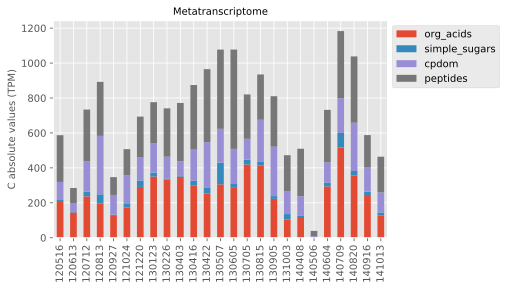

In [45]:
mt_org_aci_sum = mt_trans_alk.loc[mt_trans_alk.transporter.isin(organic_acids_t)].groupby("transporter").sum().sum()
mt_sim_sug_sum = mt_trans_alk.loc[mt_trans_alk.transporter.isin(simplesugars_t)].groupby("transporter").sum().sum()
mt_cpdom_sum = mt_trans_alk.loc[mt_trans_alk.transporter.isin(cpdom_t)].groupby("transporter").sum().sum()
mt_pep_sum = mt_trans_alk.loc[mt_trans_alk.transporter.isin(peps_t)].groupby("transporter").sum().sum()
mt_other_sum = mt_trans_alk.loc[mt_trans_alk.transporter.isin(other_t)].groupby("transporter").sum().sum()

mt_c_ratio = pd.DataFrame()
mt_c_ratio = mt_c_ratio.assign(org_acids=pd.Series(mt_org_aci_sum))
mt_c_ratio = mt_c_ratio.assign(simple_sugars=pd.Series(mt_sim_sug_sum))
mt_c_ratio = mt_c_ratio.assign(cpdom=pd.Series(mt_cpdom_sum))
mt_c_ratio = mt_c_ratio.assign(peptides=pd.Series(mt_pep_sum))
#mt_c_ratio = mt_c_ratio.assign(other=pd.Series(mt_other_sum))

mt_c_ration = mt_c_ratio.T.div(mt_c_ratio.T.sum())

ax = mt_c_ratio.plot(kind="bar", stacked=True)
ax.set_ylabel("C absolute values (TPM)", fontsize=10)
ax.set_title("Metatranscriptome", fontsize=10)
plt.legend(bbox_to_anchor=(1,1))
mt_c_ratio.to_csv("model/results/mt_c_ratios_absolute.tsv", sep="\t")
plt.savefig("model/figures/mt_c_ratios_absolute.png", dpi=300, bbox_inches="tight")


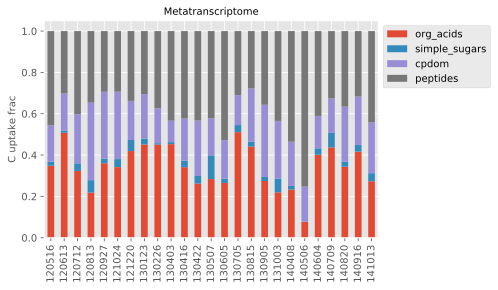

In [46]:
ax = mt_c_ration.T.plot(kind="bar", stacked=True)
ax.set_ylabel("C uptake frac", fontsize=10)
ax.set_title("Metatranscriptome", fontsize=10)
plt.legend(bbox_to_anchor=(1,1))
mt_c_ration.to_csv("model/results/mt_c_ratios.tsv", sep="\t")
plt.savefig("model/figures/mt_c_ratios.png", dpi=300, bbox_inches="tight")

#### Monthly averages

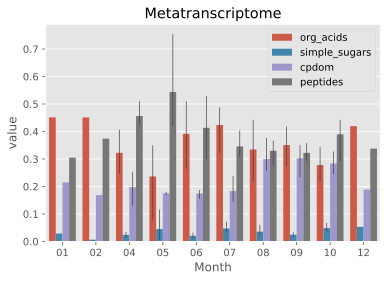

In [47]:
_ = pd.melt(mt_c_ration.reset_index(), id_vars=["index"], var_name="Date")
_.columns = ["substrate", "Date", "value"]
months = ["".join(list(x)[2:4]) for x in _.Date]
_ = _.assign(Month=pd.Series(months, index=_.index))
ax = sns.barplot(data=_, x="Month", y="value", hue="substrate", errwidth=.7)
ax.legend(bbox_to_anchor=(1,1))
ax.set_title("Metatranscriptome")
pd.pivot_table(_.groupby(["substrate", "Month"]).mean().reset_index(), columns="Month",index="substrate")["value"].to_csv("model/results/mt_c_ratios_monthly.tsv", sep="\t")
plt.savefig("model/figures/mt_c_ratios_monthly.png", dpi=300, bbox_to_inches="tight")